# **Detection of IoT botnet attacks**

Dataset: http://archive.ics.uci.edu/ml/datasets/detection_of_IoT_botnet_attacks_N_BaIoT

**About the problem:**

One of the biggest problems of IoT today is security. People say "S" in "IoT" stands for security. IoT is plagued by an epidemy of botnets, caused by very weak protection on most devices, such as smart security cameras, smart doorbells, smart thermometers, etc. These botnet are then used for various network attacks. It's very important to catch the infection as early as possible.

This datasets aims at distinguishing between benign and malicious traffic data by means of anomaly detection techniques. Malicious data can be divided into 10 attacks carried by 2 botnets (BASHLITE and mirai). There are a total of 9 IoT devices used in this dataset. Rows in the dataset represent features found in time windows of a packet stream: a total of 23 features are extracted from a single window, there are total of five windows: 100ms, 500ms, 1.5sec, 10sec, and 1min into the past (λ = 5, 3, 1, 0.1, 0.01), thus totaling 115 features per row.

We have decided to focus on predicting whether on not traffic coming from a device is malitious. After finding a good set of features and a good estimator, we will train the model on one device and test it on the other in order to prove that prediction works.

In [14]:
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectKBest, f_classif

%matplotlib inline
warnings.filterwarnings('ignore')

sns.set()

In [2]:
#These will get rid of "..." in output of methods like .describe()
#I commented them out because they seem to cause trouble on github.

#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

As the dataset is very large, we repacked the data a bit (we included the sample we used in our submission).

Function bellow reads the data on one device and adds labels to it.

In [3]:
#returns a dataframe constructed from data of ONE device

#folderpath -       path to the data folder

#BASHLITE_only -    whether function will use only BASHLITE data, or both BASHLITE and mirai.

#equalize_classes - 0) off
#                   1) BASHLITE and mirai will get squished to the size of Bening,
#                   so all classes will have roughly the same size.
#                   2) will take next arg for what size should the botnets be compared to benign 
#                   (i.e. 0.3 will provide botnet data with a 30% of benign data size) BASHLITE and 
#                   mirai will always be equal to each other in size. Useful for making datasets 
#                   imbalanced toward benign.
#
#botnet_size        (float) see above

def read_device_data(folderpath, BASHLITE_only=False, equalize_classes=1, botnet_size=0.5):
    df_benign = pd.read_csv(folderpath + 'benign_traffic.csv')
    df_bashlite = [pd.DataFrame for i in range(5)]
    df_mirai = [pd.DataFrame for i in range(5)]
    df_bashlite[0] = pd.read_csv((folderpath + 'combo_bashlite.csv'))
    df_bashlite[1] = pd.read_csv((folderpath + 'junk_bashlite.csv'))
    df_bashlite[2] = pd.read_csv((folderpath + 'scan_bashlite.csv'))
    df_bashlite[3] = pd.read_csv((folderpath + 'tcp_bashlite.csv'))
    df_bashlite[4] = pd.read_csv((folderpath + 'udp_bashlite.csv'))
    if(not(BASHLITE_only)):
        df_mirai[0] = pd.read_csv((folderpath + 'ack_mirai.csv'))
        df_mirai[1] = pd.read_csv((folderpath + 'scan_mirai.csv'))
        df_mirai[2] = pd.read_csv((folderpath + 'syn_mirai.csv'))
        df_mirai[3] = pd.read_csv((folderpath + 'udpplain_mirai.csv'))
        df_mirai[4] = pd.read_csv((folderpath + 'udp_mirai.csv'))
    benign_size = df_benign.shape[0]
    print("size of benign :", benign_size)
    bashlite_size = 0
    mirai_size = 0
    for i in range(5):
        bashlite_size += df_bashlite[i].shape[0]
    print("full size of BASHLITE :", bashlite_size)
    if(not(BASHLITE_only)):
        for i in range(5):
            mirai_size += df_mirai[i].shape[0]
        print("full size of mirai :", mirai_size)
    if(equalize_classes != 0):
        bashlite_border = 0
        mirai_border = 0
        if(equalize_classes == 1):  
            bashlite_border = bashlite_size / benign_size
            if(not(BASHLITE_only)):
                mirai_border = mirai_size / benign_size
        if(equalize_classes == 2):
            if(BASHLITE_only):
                bashlite_border = int(benign_size * botnet_size)
                bashlite_border = bashlite_size / bashlite_border
            else:
                bashlite_border = int(benign_size * botnet_size / 2)
                bashlite_border = bashlite_size / bashlite_border
                mirai_border = int(benign_size * botnet_size / 2)
                mirai_border = mirai_size / mirai_border
        for i in range(5):
            amount = int(df_bashlite[i].shape[0] // bashlite_border)
            #print(amount)
            df_bashlite[i] = shuffle(df_bashlite[i])
            df_bashlite[i].drop(df_bashlite[i].index[amount:], inplace=True)
            if(not(BASHLITE_only)):
                amount = int(df_mirai[i].shape[0] // mirai_border)
                #print(amount)
                df_mirai[i] = shuffle(df_mirai[i])
                df_mirai[i].drop(df_mirai[i].index[amount:], inplace=True)
        bashlite_size = 0
        for i in range(5):
            bashlite_size += df_bashlite[i].shape[0]
        print("squished size of BASHLITE :", bashlite_size)
        if(not(BASHLITE_only)):
            mirai_size = 0
            for i in range(5):
                mirai_size += df_mirai[i].shape[0]
            print("squished size of mirai :", mirai_size)
    df_benign['Botnet'] = 1
    df_botnet = pd.concat(df_bashlite, ignore_index=True)
    df_botnet['Botnet'] = -1
    if(not(BASHLITE_only)):
        df_botnet_mirai = pd.concat(df_mirai, ignore_index=True)
        df_botnet_mirai['Botnet'] = -1
        df_botnet = pd.concat([df_botnet, df_botnet_mirai], ignore_index=True)
    
    res = pd.concat([df_benign, df_botnet], ignore_index=True)
    res = shuffle(res)
    print("full dataframe size :", res.shape[0])
    return res

In [4]:
data = read_device_data('.\\data\\doorbell\\',  BASHLITE_only=True)

size of benign : 40395
full size of BASHLITE : 316650
squished size of BASHLITE : 40393
full dataframe size : 80788


In [5]:
pd.set_option('display.max_columns', None)
data.describe()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,MI_dir_L0.1_mean,MI_dir_L0.1_variance,MI_dir_L0.01_weight,MI_dir_L0.01_mean,MI_dir_L0.01_variance,H_L5_weight,H_L5_mean,H_L5_variance,H_L3_weight,H_L3_mean,H_L3_variance,H_L1_weight,H_L1_mean,H_L1_variance,H_L0.1_weight,H_L0.1_mean,H_L0.1_variance,H_L0.01_weight,H_L0.01_mean,H_L0.01_variance,HH_L5_weight,HH_L5_mean,HH_L5_std,HH_L5_magnitude,HH_L5_radius,HH_L5_covariance,HH_L5_pcc,HH_L3_weight,HH_L3_mean,HH_L3_std,HH_L3_magnitude,HH_L3_radius,HH_L3_covariance,HH_L3_pcc,HH_L1_weight,HH_L1_mean,HH_L1_std,HH_L1_magnitude,HH_L1_radius,HH_L1_covariance,HH_L1_pcc,HH_L0.1_weight,HH_L0.1_mean,HH_L0.1_std,HH_L0.1_magnitude,HH_L0.1_radius,HH_L0.1_covariance,HH_L0.1_pcc,HH_L0.01_weight,HH_L0.01_mean,HH_L0.01_std,HH_L0.01_magnitude,HH_L0.01_radius,HH_L0.01_covariance,HH_L0.01_pcc,HH_jit_L5_weight,HH_jit_L5_mean,HH_jit_L5_variance,HH_jit_L3_weight,HH_jit_L3_mean,HH_jit_L3_variance,HH_jit_L1_weight,HH_jit_L1_mean,HH_jit_L1_variance,HH_jit_L0.1_weight,HH_jit_L0.1_mean,HH_jit_L0.1_variance,HH_jit_L0.01_weight,HH_jit_L0.01_mean,HH_jit_L0.01_variance,HpHp_L5_weight,HpHp_L5_mean,HpHp_L5_std,HpHp_L5_magnitude,HpHp_L5_radius,HpHp_L5_covariance,HpHp_L5_pcc,HpHp_L3_weight,HpHp_L3_mean,HpHp_L3_std,HpHp_L3_magnitude,HpHp_L3_radius,HpHp_L3_covariance,HpHp_L3_pcc,HpHp_L1_weight,HpHp_L1_mean,HpHp_L1_std,HpHp_L1_magnitude,HpHp_L1_radius,HpHp_L1_covariance,HpHp_L1_pcc,HpHp_L0.1_weight,HpHp_L0.1_mean,HpHp_L0.1_std,HpHp_L0.1_magnitude,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Botnet
count,80788.000000,80788.000000,8.078800e+04,80788.000000,80788.000000,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,80788.000000,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,8.078800e+04,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,80788.000000,8.078800e+04,8.078800e+04,80788.000000,80788.000000,80788.000000,80788.000000,80788.000000,8.078800e+04,8.078800e+04,80788.000000,80788.000000
mean,26.715364,79.031282,1.342500e+02,42.331301,79.029413,1.491561e+02,117.824723,79.253209,175.943137,943.967120,79.838614,246.119230,3184.812187,79.106148,271.464522,26.715364,79.031282,1.342500e+02,42.331301,79.029413,1.491561e+02,117.824724,79.253201,175.943245,943.967160,79.838424,246.120447,3184.812364,79.105634,271.466465,23.722261,78.988912,1.199508e-01,101.118396,2.461958e+01,0.174314,0.000109,38.245714,78.986273,0.180721,101.118034,2.706362e+01,0.241249,0.000263,109.461268,79.047870,7.604807e-01,101.199878,4.194663e+01,4.989667e-01,0.002215,892.287101,79.492403,3.207919e+00,101.890060,1.753993e+02,1.255310e+01,1.937903e-02,2834.112596,79.076613,3.718962,101.543083,2.550601e+02,3.09858

As we are planning to try ensembles of trees first, no data normalization is required.

Check if there any null values:

In [6]:
data.isnull().values.any()

False

In [7]:
data.corr()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,MI_dir_L0.1_mean,MI_dir_L0.1_variance,MI_dir_L0.01_weight,MI_dir_L0.01_mean,MI_dir_L0.01_variance,H_L5_weight,H_L5_mean,H_L5_variance,H_L3_weight,H_L3_mean,H_L3_variance,H_L1_weight,H_L1_mean,H_L1_variance,H_L0.1_weight,H_L0.1_mean,H_L0.1_variance,H_L0.01_weight,H_L0.01_mean,H_L0.01_variance,HH_L5_weight,HH_L5_mean,HH_L5_std,HH_L5_magnitude,HH_L5_radius,HH_L5_covariance,HH_L5_pcc,HH_L3_weight,HH_L3_mean,HH_L3_std,HH_L3_magnitude,HH_L3_radius,HH_L3_covariance,HH_L3_pcc,HH_L1_weight,HH_L1_mean,HH_L1_std,HH_L1_magnitude,HH_L1_radius,HH_L1_covariance,HH_L1_pcc,HH_L0.1_weight,HH_L0.1_mean,HH_L0.1_std,HH_L0.1_magnitude,HH_L0.1_radius,HH_L0.1_covariance,HH_L0.1_pcc,HH_L0.01_weight,HH_L0.01_mean,HH_L0.01_std,HH_L0.01_magnitude,HH_L0.01_radius,HH_L0.01_covariance,HH_L0.01_pcc,HH_jit_L5_weight,HH_jit_L5_mean,HH_jit_L5_variance,HH_jit_L3_weight,HH_jit_L3_mean,HH_jit_L3_variance,HH_jit_L1_weight,HH_jit_L1_mean,HH_jit_L1_variance,HH_jit_L0.1_weight,HH_jit_L0.1_mean,HH_jit_L0.1_variance,HH_jit_L0.01_weight,HH_jit_L0.01_mean,HH_jit_L0.01_variance,HpHp_L5_weight,HpHp_L5_mean,HpHp_L5_std,HpHp_L5_magnitude,HpHp_L5_radius,HpHp_L5_covariance,HpHp_L5_pcc,HpHp_L3_weight,HpHp_L3_mean,HpHp_L3_std,HpHp_L3_magnitude,HpHp_L3_radius,HpHp_L3_covariance,HpHp_L3_pcc,HpHp_L1_weight,HpHp_L1_mean,HpHp_L1_std,HpHp_L1_magnitude,HpHp_L1_radius,HpHp_L1_covariance,HpHp_L1_pcc,HpHp_L0.1_weight,HpHp_L0.1_mean,HpHp_L0.1_std,HpHp_L0.1_magnitude,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Botnet
MI_dir_L5_weight,1.000000,-0.088404,0.033652,0.997460,-0.089387,0.037278,0.984853,-0.097052,0.048737,0.938605,-0.132389,0.037687,0.825505,-0.125754,0.019893,1.000000,-0.088404,0.033652,0.997460,-0.089387,0.037278,0.984853,-0.097052,0.048737,0.938605,-0.132411,0.037686,0.825505,-0.125820,0.019892,0.976514,-0.081415,-0.007420,-0.053958,0.002853,-0.002944,-0.005869,0.974632,-0.081638,-0.013739,-0.053938,0.002094,-0.003420,-0.008460,0.966338,-0.083380,-0.065104,-0.054713,0.000854,-0.004445,-0.037592,0.925680,-0.095939,-0.163858,-0.064602,0.001184,0.011176,-0.083553,0.813377,-0.087753,-0.170718,-0.063972,0.003124,0.013175,-0.155496,0.976514,-0.283182,-0.005128,0.974632,-0.283181,-0.002166,0.966338,-0.282301,0.047823,0.925680,-0.276792,0.064828,0.813377,-0.275871,0.060398,-0.021129,-0.080374,-0.002390,-0.158961,0.001752,-0.002834,-0.002583,-0.022061,-0.080420,-0.003045,-0.159004,0.000474,-0.003185,-0.003118,-0.011291,-0.080495,-0.002875,-0.159038,-0.000651,-0.003940,-0.004307,-0.017873,-0.080138,0.006980,-0.163416,0.011072,0.016654,0.010695,-0.197078,-0.079832,0.005911,-0.166098,0.012298,0.016692,0.005591,-0.425819
MI_dir_L5_mean,-0.088404,1.000000,0.233617,-0.092756,0.994660,0.248648,-0.095259,0.960700,0.161298,-0.090487,0.819616,0.119718,-0.080489,0.745435,0.149058,-0.088404,1.000000,0.233617,-0.092756,0.994660,0.248648,-0.095259,0.960700,0.161299,-0.090487,0.819615,0.119732,-0.080489,0.745424,0.149083,-0.094216,0.904315,0.052742,0.758840,0.014571,0.015997,-0.000325,-0.094592,0.905258,0.058124,0.758379,0.019722,0.012468,-0.006241,-0.093967,0.904775,-0.015222,0.756111,0.028563,0.003101,-0.071469,-0.088686,0.864518,0.002639,0.752894,0.022384,-0.010926,-0.144709,-0.078100,0.812485,0.021525,0.763772,0.012876,-0.004560,-0.068560,-0.094216,-0.642096,0.009929,-0.094592,-0.642110,0.009537,-0.093967,-0.643834,-0.012148,-0.088686,-0.648918,-0.017403,-0.078100,-0.648621,-0.007836,-0.037984,0.893231,0.032244,0.805604,0.022192,0.017067,0.015023,-0.030395,0.893259,0.036086,0.805681,0.030627,0.018617,0.016609,-0.014886,0.893107,0.035425,0.805849,0.033118,0.019759,0.017465,0.009112,0.892107,0.016075,0.825304,-0.002222,-0.002853,0.006070,0.249249,0.891164,0.019929,0.837994,-0.003214,-0.003845,0.0200

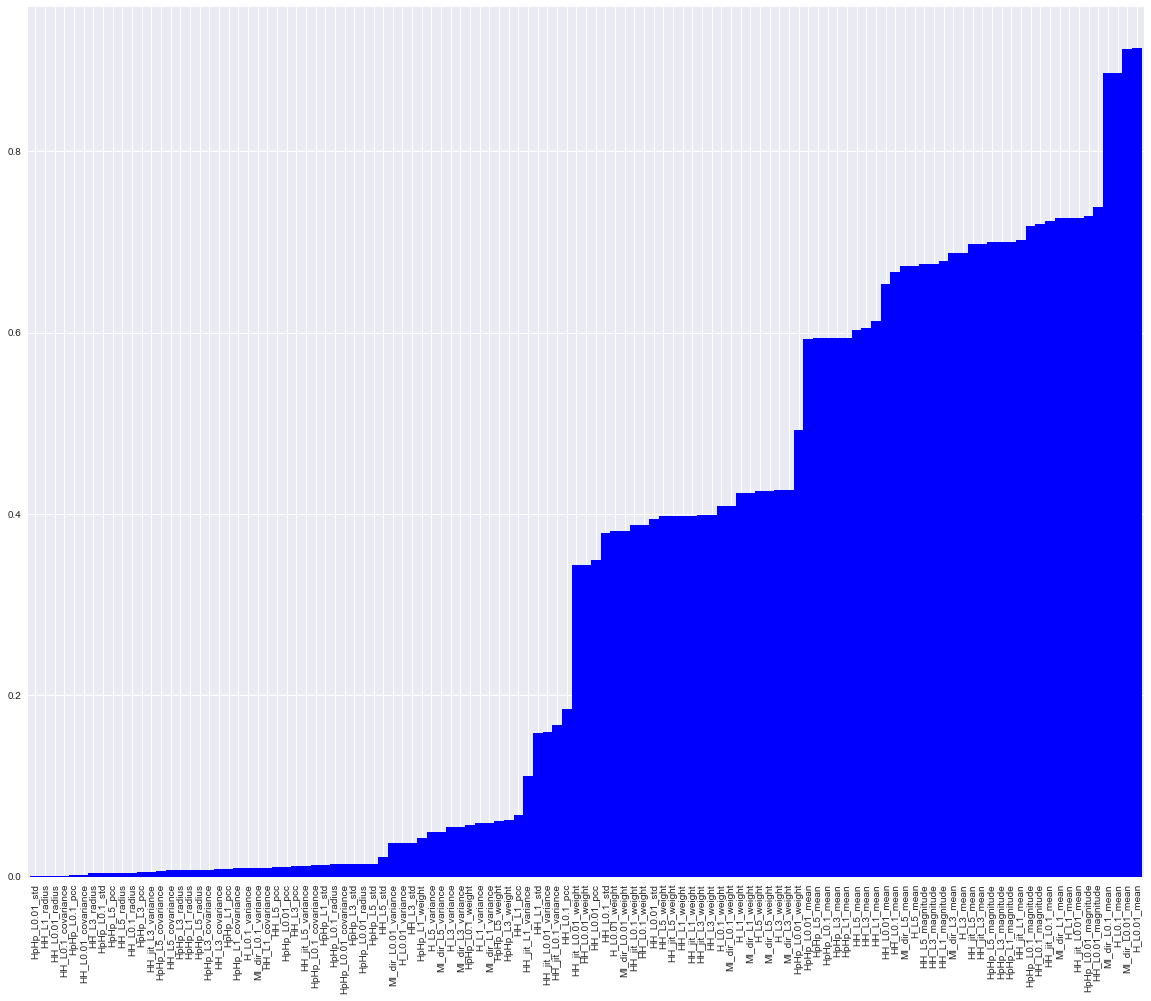

In [8]:
x = data.corr()['Botnet'].drop(['Botnet']).abs().sort_values(ascending=True)
fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111)
x.plot(kind='bar', color='blue', ax=ax, width=1)
plt.show()

We see a srong correlation between "Botnet"(output) and "H_L0.1_mean", "H_L0.01_mean, "M_dir_L0.01_mean"

We are going to apply RandomForest and Isolation Forest, because Isolation Forest is often used for detecting anomalies and Randon Forest is bal-bla and they both do not require normalization.

Therefore, we will check feature importances for these two algorithms. 

First, for random forest. We have a large dataset, so we will check on smaller dataset.

In [9]:
data10thpart = data.drop(data.index[10000:])
y10thpart = data10thpart['Botnet']
data10thpart = data10thpart.drop(['Botnet'], axis=1)

In [10]:
clf = RandomForestClassifier()

clf.fit(data10thpart, y10thpart)
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = data10thpart.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                       importance
HH_L0.01_mean            0.287403
MI_dir_L0.01_mean        0.201704
HH_jit_L0.1_mean         0.192191
HpHp_L0.01_weight        0.095935
HH_L0.1_magnitude        0.094809
H_L3_weight              0.055487
MI_dir_L0.1_weight       0.044193
HH_jit_L0.01_mean        0.007535
H_L0.01_mean             0.004260
H_L0.1_mean              0.004174
MI_dir_L0.1_mean         0.002115
HH_L5_magnitude          0.001904
H_L0.01_weight           0.001673
HpHp_L0.01_mean          0.001277
HH_L0.1_weight           0.000798
HH_L0.01_radius          0.000717
HH_L1_std                0.000612
H_L0.1_weight            0.000598
MI_dir_L5_weight         0.000558
HH_jit_L0.01_weight      0.000440
HH_jit_L3_variance       0.000410
HH_L0.01_magnitude       0.000166
H_L5_variance            0.000138
HH_jit_L1_variance       0.000120
MI_dir_L3_weight         0.000103
H_L1_weight              0.000080
HpHp_L0.1_weight         0.000080
HpHp_L3_radius           0.000080
MI_dir_L1_weig

In [15]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(SelectKBest(f_classif, 11), 
                     clf)

scores = cross_val_score(pipe, data10thpart, y10thpart, scoring='accuracy', cv=5)
print('Accuracy of classification is {:0.5f} +- {:0.5f}'.format(np.mean(scores), np.std(scores)))

Accuracy of classification is 0.99990 +- 0.00020


We got the highest score with 11 features. Also we checked 7, 8, 9, 10, 12, 13 ,14.

Now, for isolation forest

In [17]:
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

clf = IsolationForest()
selector = SelectKBest(f_classif, 11)
selector.fit(data10thpart, y10thpart)
# SelectKBest just selects the specified number of features with the highest scores 
print(data10thpart.shape)
data_reduced = selector.transform(data10thpart)

feature_names = list(data10thpart.columns.values)
mask = selector.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        
print(new_features)
print("-----------------------------------------------------------")
print(np.mean(cross_val_score(clf, data_reduced, y10thpart, cv=5, scoring='accuracy')))

(10000, 115)
['MI_dir_L1_mean', 'MI_dir_L0.1_mean', 'MI_dir_L0.01_mean', 'H_L3_mean', 'H_L1_mean', 'H_L0.1_mean', 'H_L0.01_mean', 'HH_L0.1_mean', 'HH_L0.01_mean', 'HH_jit_L0.1_mean', 'HH_jit_L0.01_mean']
-----------------------------------------------------------
0.4835


I got the highest score with 11 features.Also I tried amount 7, 9, 10, 12, 13, 14, 20 features.

We got results: **from correlation:** "H_L0.1_mean", "H_L0.01_mean, "M_dir_L0.01_mean";


**from RF:** MI_dir_L0.1_mean, MI_dir_L0.01_mean, HpHp_L0.01_weight, H_L0.01_mean, HH_L0.01_magnitude, MI_dir_L0.1_mean, HH_L0.01_mean, HH_jit_L0.1_mean, HH_L0.1_mean, HpHp_L0.1_magnitude, HpHp_L1_magnitude, H_L0.01_weight.    


**from IF:** 'MI_dir_L1_mean', 'MI_dir_L0.1_mean', 'MI_dir_L0.01_mean', 'H_L1_mean', 'H_L0.1_mean', 'H_L0.01_mean', 'HH_jit_L5_mean', 'HH_jit_L3_mean', 'HH_jit_L1_mean', 'HH_jit_L0.1_mean', 'HH_jit_L0.01_mean'.

In [18]:
def drop_columns_rf(data):
    return pd.concat(([data['MI_dir_L0.1_mean'], 
                    data['MI_dir_L0.01_mean'], 
                    data['H_L0.01_mean'], 
                    data['HH_L0.1_magnitude'], 
                    data['HH_L0.01_magnitude'], 
                    data['HH_L0.01_mean'], 
                    data['HpHp_L0.01_mean'], 
                    data['HpHp_L1_magnitude'], 
                    data['HpHp_L1_mean'], 
                    data['H_L0.1_mean']]), axis=1)

In [19]:
def drop_columns_if(data):
    return pd.concat(([data['MI_dir_L0.1_mean'], 
                    data['MI_dir_L1_mean'], 
                    data['MI_dir_L0.01_mean'],
                    data['H_L1_mean'], 
                    data['H_L0.1_mean'], 
                    data['H_L0.01_mean'], 
                    data['HH_jit_L3_mean'], 
                    data['HH_jit_L1_mean'], 
                    data['HH_jit_L0.1_mean'], 
                    data['HH_jit_L0.01_mean']]), axis=1)

We see, that RF is better than IF. Let us look for a good set of hyperparameters.

In [20]:
y = data['Botnet']
X = drop_columns_rf(data)
X.shape

(80788, 10)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train.shape

(60591, 10)

In [22]:
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=0)

clf_params = [{ 
    "n_estimators": [2, 3, 4, 5, 6],
    "min_samples_split": [2],
    "min_samples_leaf": [1, 2]
    
}]

clf_grid = GridSearchCV(clf, clf_params, cv=5, refit=True, verbose=1, n_jobs=-1)
clf_grid.fit(X_train, y_train)
clf_best = clf_grid.best_estimator_
print("Accuracy (random forest auto): {} with params {}"
      .format(clf_grid.best_score_, clf_grid.best_params_))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   29.2s finished


Accuracy (random forest auto): 0.9996864220758859 with params {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}


[backup]Accuracy (random forest auto): 0.9997689425822317 with params {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 3}

In [23]:
clf = RandomForestClassifier(n_estimators=3,
 min_samples_split=2,
 min_samples_leaf=1)
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
print('RF score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

RF score: 1.000 ± 0.000


In [24]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy of prediction is {}'.format(accuracy_score(y_test, y_pred)))

Accuracy of prediction is 0.99960390156954


How does IF work here?

First, look for hyoerparameters too.

In [ ]:
clf = IsolationForest()

#We have already had this grid search done, it took over 150 min. We had to re-run the notebook,
#so this is commented out for now and the best params are used in the next cell.
'''
clf_params = [{ 
    "n_estimators": [100, 200, 300, 400, 500],
    "max_samples": [50, 100, 200, 256, 300, 400, 500],
    "contamination": [0.1, 0.2, 0.3, 0.4, 0.5], 
    "random_state": [0]
    
}]


clf_grid = GridSearchCV(clf, clf_params, cv=5, scoring='accuracy', refit=True, verbose=1, n_jobs=-1)
clf_grid.fit(X_train, y_train)
clf_best = clf_grid.best_estimator_
print("Accuracy (isolation forest auto): {} with params {}"
      .format(clf_grid.best_score_, clf_grid.best_params_))
'''

[backup] Accuracy (isolation forest auto): 0.495411935569052 with params {'contamination': 0.1, 'max_samples': 50, 'n_estimators': 300, 'random_state': 0}

In [27]:
clf = IsolationForest(n_estimators=300, contamination=0.1, max_samples=50)
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5)
print('IF score: {0:.3f} ± {1:.3f}'.format(scores.mean(), scores.std()) )

IF score: 0.451 ± 0.007


In [28]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy of prediction is {}'.format(accuracy_score(y_test, y_pred)))

Accuracy of prediction is 0.4553151458137347


In [29]:
un, counts = np.unique(y_pred, return_counts=True)
print(np.asarray((un, counts)).T)

[[   -1  1959]
 [    1 18238]]


In [30]:
un, counts = np.unique(y_test, return_counts=True)
print(np.asarray((un, counts)).T)

[[   -1 10140]
 [    1 10057]]


Let us check our model on unbalanced dataset.

In [31]:
# upload new data from the other device
unbal_data = read_device_data('.\\data\\thermostat\\',  BASHLITE_only=True, equalize_classes=2, botnet_size=0.1)

size of benign : 13111
full size of BASHLITE : 310630
squished size of BASHLITE : 1309
full dataframe size : 14420


In [32]:
y_unbal = unbal_data['Botnet']
X_unbal = drop_columns_rf(unbal_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [33]:
clf = RandomForestClassifier(n_estimators=3,
 min_samples_split=2,
 min_samples_leaf=1)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_unbal)
print('Accuracy of prediction is {}'.format(accuracy_score(y_unbal, y_pred)))
print('f1_score_macro of prediction is {}'.format(f1_score(y_unbal, y_pred, average='macro')))
print('f1_score_micro of prediction is {}'.format(f1_score(y_unbal, y_pred, average='micro')))
print('f1_score_weighted of prediction is {}'.format(f1_score(y_unbal, y_pred, average='weighted')))

Accuracy of prediction is 0.25339805825242717
f1_score_macro of prediction is 0.24952436177308834
f1_score_micro of prediction is 0.25339805825242717
f1_score_weighted of prediction is 0.2936530932877185


We see that on unbalanced data our model works worse.

Let us check the model on only benign and malicious data.
First, malicious.

In [34]:
path = ".\\data/thermostat/udp_bashlite.csv"
udp = pd.read_csv(path)
udp = shuffle(udp)
udp = drop_columns_rf(udp)
y_anom = np.empty(udp.shape[0])
y_anom.fill(-1)
y_anom

array([-1., -1., -1., ..., -1., -1., -1.])

In [35]:
y_pred = clf.predict(udp)
print('Accuracy of prediction is {}'.format(accuracy_score(y_anom, y_pred)))
print('f1_micro of prediction is {}'.format(f1_score(y_anom, y_pred, average='micro')))
print('f1_macro of prediction is {}'.format(f1_score(y_anom, y_pred, average='macro')))

Accuracy of prediction is 0.9996087450258133
f1_micro of prediction is 0.9996087450258133
f1_macro of prediction is 0.4999021671176524


Now, on benign.

In [36]:
path = ".\\data/thermostat/benign_traffic.csv"
ben = pd.read_csv(path)
ben = shuffle(ben)
ben = drop_columns_rf(ben)
y_ben = np.empty(ben.shape[0])
y_ben.fill(1)
y_ben

array([1., 1., 1., ..., 1., 1., 1.])

In [37]:
y_pred = clf.predict(ben)
print('Accuracy of prediction is {}'.format(accuracy_score(y_ben, y_pred)))
print('f1_micro of prediction is {}'.format(f1_score(y_ben, y_pred, average='micro')))
print('f1_macro of prediction is {}'.format(f1_score(y_ben, y_pred, average='macro')))

Accuracy of prediction is 0.1788574479444741
f1_micro of prediction is 0.1788574479444741
f1_macro of prediction is 0.1517210144927536


Now we can understand that our model makes mistakes on benign traffic. It puts -1 when it is 1 frequently.

Let us check IF, but we have to train it on unbalanced data.

In [38]:
unbal_data = read_device_data('.\\data\\doorbell\\',  BASHLITE_only=True, equalize_classes=2, botnet_size=0.1)

size of benign : 40395
full size of BASHLITE : 316650
squished size of BASHLITE : 4036
full dataframe size : 44431


In [39]:
unbal_y = unbal_data['Botnet']
unbal_data = unbal_data.drop(['Botnet'], axis=1)
unbal_data.shape

(44431, 115)

In [40]:
from sklearn.model_selection import StratifiedKFold

clf = IsolationForest()
selector = SelectKBest(f_classif, 11)
selector.fit(unbal_data, unbal_y)
# SelectKBest just selects the specified number of features with the highest scores 
print(unbal_data.shape)
data_reduced = selector.transform(unbal_data)

feature_names = list(unbal_data.columns.values)
mask = selector.get_support() #list of booleans
new_features = [] # The list of your K best features

for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
        
print(new_features)
print("-----------------------------------------------------------")
cv = StratifiedKFold(n_splits=5)
print(np.mean(cross_val_score(clf, data_reduced, unbal_y, cv=cv, scoring='accuracy')))
print(np.mean(cross_val_score(clf, data_reduced, unbal_y, cv=cv, scoring='f1_macro')))
print(np.mean(cross_val_score(clf, data_reduced, unbal_y, cv=cv, scoring='f1_micro')))

(44431, 115)
['MI_dir_L0.1_mean', 'MI_dir_L0.01_mean', 'H_L0.1_mean', 'H_L0.01_mean', 'HH_L0.1_magnitude', 'HH_L0.01_magnitude', 'HH_jit_L5_mean', 'HH_jit_L3_mean', 'HH_jit_L1_mean', 'HH_jit_L0.1_mean', 'HH_jit_L0.01_mean']
-----------------------------------------------------------
0.98645095354201
0.9643777805693802
0.986788492352059


We got better results.

We got 11 best features: 'MI_dir_L0.1_mean', 'MI_dir_L0.01_mean', 'H_L0.1_mean', 'H_L0.01_mean', 'HH_L0.1_magnitude', 'HH_L0.01_magnitude', 'HH_jit_L5_mean', 'HH_jit_L3_mean', 'HH_jit_L1_mean', 'HH_jit_L0.1_mean', 'HH_jit_L0.01_mean'

Changing drop function:

In [41]:
def drop_columns(data):
    return pd.concat(([data['MI_dir_L0.1_mean'], 
                    data['HH_L0.01_magnitude'], 
                    data['MI_dir_L0.01_mean'],
                    data['HH_L0.1_magnitude'], 
                    data['H_L0.1_mean'], 
                    data['H_L0.01_mean'], 
                    data['HH_jit_L3_mean'], 
                    data['HH_jit_L1_mean'], 
                    data['HH_jit_L0.1_mean'], 
                    data['HH_jit_L0.01_mean']]), axis=1)

In [42]:
unbal_data = drop_columns(unbal_data)
unbal_data.shape

(44431, 10)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(unbal_data, unbal_y, test_size=0.25, random_state=0)

In [44]:
clf = IsolationForest()
clf_params = [{ 
    "n_estimators": [50, 100, 200],
    "max_samples": [50, 100, 200, 256, 300],
    "contamination": [0.1, 0.2, 0.3], 
    "random_state": [0]
    
}]


clf_grid = GridSearchCV(clf, clf_params, cv=cv, scoring='f1_macro', refit=True, verbose=1, n_jobs=-1)
clf_grid.fit(X_train, y_train)
clf_best = clf_grid.best_estimator_
print("f1_macro (isolation forest auto): {} with params {}"
      .format(clf_grid.best_score_, clf_grid.best_params_))

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 225 out of 225 | elapsed:  8.4min finished


f1_macro (isolation forest auto): 0.9749004222225159 with params {'contamination': 0.1, 'max_samples': 100, 'n_estimators': 200, 'random_state': 0}


[backup]f1_macro (isolation forest auto): 0.9733802867987968 with params {'contamination': 0.1, 'max_samples': 200, 'n_estimators': 100, 'random_state': 0}

In [45]:
clf = IsolationForest(n_estimators=100, contamination=0.1, max_samples=200, random_state=0)
scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv)
print('IF score: {0:.5f} ± {1:.5f}'.format(scores.mean(), scores.std()) )
scores = cross_val_score(clf, X_train, y_train, scoring='f1_macro', cv=cv)
print('IF score: {0:.5f} ± {1:.5f}'.format(scores.mean(), scores.std()) )
scores = cross_val_score(clf, X_train, y_train, scoring='f1_micro', cv=cv)
print('IF score: {0:.5f} ± {1:.5f}'.format(scores.mean(), scores.std()) )

IF score: 0.99043 ± 0.00198
IF score: 0.97235 ± 0.00558
IF score: 0.99043 ± 0.00198


In [46]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print('Accuracy of prediction is {}'.format(accuracy_score(y_test, y_pred)))
print('f1_micro of prediction is {}'.format(f1_score(y_test, y_pred, average='micro')))
print('f1_macro of prediction is {}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy of prediction is 0.9901872524306806
f1_micro of prediction is 0.9901872524306806
f1_macro of prediction is 0.9714962500622975


In [47]:
y_pred

array([ 1,  1, -1, ...,  1,  1,  1])